# Creating a Kaggle Workflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing the Data

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def kaggle_proccesing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, 'Age_categories')
    df = create_dummies(df, 'Fare_categories')
    df = create_dummies(df, 'Title')
    df = create_dummies(df, 'Cabin_type')
    df = create_dummies(df, 'Sex')
    return df

In [5]:
train = kaggle_proccesing(train)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0


In [6]:
holdout = kaggle_proccesing(holdout)
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,0,1,0,1


## Exploring the Data

In [7]:
train[['SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


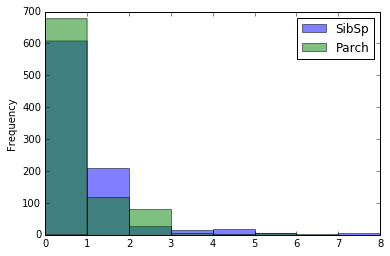

In [8]:
explore = train[['SibSp', 'Parch', 'Survived']]
explore[['SibSp', 'Parch']].plot.hist(alpha=0.5,bins=8)
plt.show()

In [9]:
explore['family_members'] = explore['SibSp'] + explore['Parch']
explore[['SibSp', 'Parch', 'family_members']].head()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,SibSp,Parch,family_members
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0


In [10]:
def with_family(row):
    if row == 0:
        return 0
    else:
        return 1
explore['with_family'] = explore['family_members'].apply(with_family)
explore['with_family'].head()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0    1
1    1
2    0
3    1
4    0
Name: with_family, dtype: int64

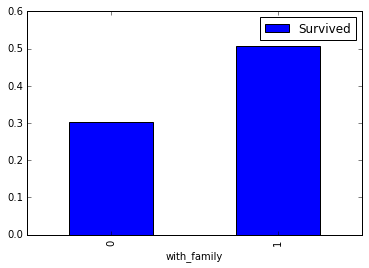

In [11]:
pd.pivot_table(explore[['with_family', 'Survived']], values='Survived', index='with_family').plot.bar()

## Engineering New Features

In [12]:
def is_alone(row):
    if (row['SibSp'] + row['Parch']) == 0:
        return 1
    else:
        return 0
train['is_alone'] = train.apply(is_alone, axis=1)
holdout['is_alone'] = holdout.apply(is_alone, axis=1)
train['is_alone'].head()

0    0
1    0
2    1
3    0
4    1
Name: is_alone, dtype: int64

## Selecting the Best-Performing Features

In [13]:
def select_features(df):
    df = df.select_dtypes('number')
    df = df.dropna(axis=1)
    all_X = df.drop(['PassengerId', 'Survived'],axis=1)
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf,cv=10)
    selector.fit(all_X,all_y)
    print(all_X.columns[selector.support_])
    return(all_X.columns[selector.support_])

optimized_columns = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'is_alone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Selecting and Tuning Different Algorithms

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,optimized_columns)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'p': 1, 'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'brute'}

RandomForestClassifier
----------------------
Best Score: 0.8294051627384961
Best Parameters: {'max_features': 'log2', 'criterion': 'entropy', 'min_samples_split': 5, 'min_samples_leaf': 1, 'n_estimators': 4, 'max_depth': 5}



## Selecting and Tuning Different Algorithms

In [17]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,optimized_columns)